# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Input Nama]
- **Email:** [Input Email]
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-12 20:28:40.541816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749760120.748481      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749760120.805998      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Data Preparation

### Data Preprocessing

In [3]:
def load_data(base_path, max_samples=None):
    data, labels = [], []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_path)
                label_parts = relative_path.split(os.sep)[1:]
                label = "_".join(label_parts[:-1])
                
                img = cv2.imread(file_path)
                if img is None:
                    continue
                img = cv2.resize(img, (128, 128))
                img = img.astype("float32") / 255.0
                
                data.append(img)
                labels.append(label)
                
                if max_samples and len(data) >= max_samples:
                    break
                
                if len(data) % 1000 == 0:
                    print(f"Loaded {len(data)} images...")
                    
    return np.array(data), np.array(labels)

In [4]:
dataset_path = '/kaggle/input/garbage-classification/'

### Split Data

In [5]:
print("Loading data...")
images, labels = load_data(dataset_path)
print("Data loaded!")

print("Encoding labels...")
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

from collections import Counter
class_counts = Counter(labels_encoded)
print("\nDistribusi kelas:")
for class_idx, count in class_counts.items():
    print(f"Kelas {label_encoder.inverse_transform([class_idx])[0]}: {count}")
    percentage = (count / len(labels_encoded)) * 100
    print(f"Persentase: {percentage:.2f}%")

print("\nSplitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

del X_temp, y_temp
gc.collect()

print(f"\nJumlah data train: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")
print(f"Jumlah data test: {len(X_test)}")
print(f"Jumlah kelas: {len(label_encoder.classes_)}")

Loading data...
Loaded 1000 images...
Loaded 2000 images...
Loaded 3000 images...
Loaded 4000 images...
Loaded 5000 images...
Data loaded!
Encoding labels...

Distribusi kelas:
Kelas Garbage classification_metal: 820
Persentase: 16.22%
Kelas Garbage classification_glass: 1002
Persentase: 19.83%
Kelas Garbage classification_paper: 1188
Persentase: 23.51%
Kelas Garbage classification_trash: 274
Persentase: 5.42%
Kelas Garbage classification_cardboard: 806
Persentase: 15.95%
Kelas Garbage classification_plastic: 964
Persentase: 19.07%

Splitting dataset...

Jumlah data train: 3537
Jumlah data validation: 1016
Jumlah data test: 501
Jumlah kelas: 6


## Modelling

In [6]:
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

input_shape = (128, 128, 3)
model = Sequential([
    Input(shape=input_shape),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1749760247.831367      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Callback and LR Reduction

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [8]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
batch_size = 32
epochs = 40

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

print("Mulai training model...")
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict,
    verbose=1
)

Mulai training model...
Epoch 1/40


I0000 00:00:1749760295.123992      98 service.cc:148] XLA service 0x7eafe0009160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749760295.124568      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749760295.419662      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2638 - loss: 1.7789

I0000 00:00:1749760297.937257      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.3297 - loss: 1.6928 - val_accuracy: 0.4459 - val_loss: 1.3810 - learning_rate: 1.0000e-04
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4943 - loss: 1.2617 - val_accuracy: 0.4626 - val_loss: 1.3217 - learning_rate: 1.0000e-04
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5259 - loss: 1.1936 - val_accuracy: 0.4823 - val_loss: 1.2647 - learning_rate: 1.0000e-04
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5996 - loss: 1.0181 - val_accuracy: 0.5728 - val_loss: 1.1363 - learning_rate: 1.0000e-04
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6115 - loss: 0.9856 - val_accuracy: 0.5807 - val_loss: 1.0617 - learning_rate: 1.0000e-04
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6468 - loss: 0.8930 - val_accuracy: 0.5994 - val_loss: 1.0333 - learning_rate: 1.0000e-04
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.69

## Evaluasi dan Visualisasi

In [12]:
train_results = model.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_results[0]}")
print(f"Train Accuracy: {train_results[1]}")

Train Loss: 0.09310494363307953
Train Accuracy: 0.9816228151321411


In [13]:
results = model.evaluate(X_test, y_test)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8975 - loss: 0.3288
Test Loss: 0.3909347355365753
Test Accuracy: 0.8902195692062378


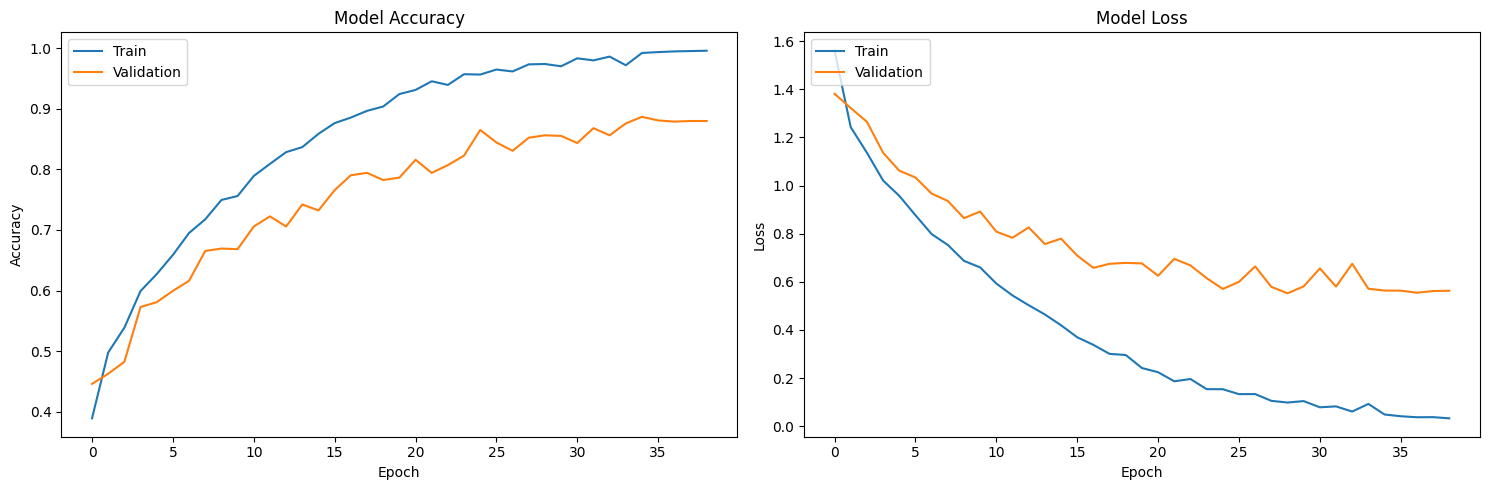

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
model.save('klasifikasi_sampah.h5')
print("Model klasifikasi disimpan!")

Model klasifikasi disimpan!


## Konversi Model

In [16]:
model = tf.keras.models.load_model('klasifikasi_sampah.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('klasifikasi_sampah.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpekohyn0q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139295119836560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119838288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119838096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119839056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119838864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119839824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119839248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119840784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119838480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139295119841936: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1749760692.184620      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749760692.184653      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749760692.190949      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [17]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [19]:
!tensorflowjs_converter --input_format=keras klasifikasi_sampah.h5 tfjs_model/

2025-06-12 20:41:38.435989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749760898.456810     728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749760898.463167     728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [20]:
import shutil
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

from IPython.display import FileLink
FileLink('tfjs_model.zip')

/kaggle/working/tfjs_model.zip